In [1]:
%load_ext autoreload
%autoreload 2

In [39]:
import pandas as pd
import glob
import fasttext
import pickle
import numpy as np
import matplotlib.pyplot as plt
from preprocess import DatasetPreprocess
from CustomModel import Model
from sklearn.model_selection import train_test_split
import csv
from pprint import pprint
import pickle
import random
import torch
import warnings
warnings.filterwarnings("ignore")

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed()

### Reading the entire dataset

In [3]:
read_full_dataset = False

In [43]:
with open('/StudentData/Project/ind_tokenizer.pkl', 'rb') as f:
    ind_to_label_mapper = pickle.load(f)
label_to_ind_mapper = {f"__label__{value}": key for key, value in ind_to_label_mapper.items()}

if read_full_dataset:
    all_files = glob.glob("/StudentData/Project/data_chunk_*.csv")

    li = []


    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0, usecols=['text','industry', 'lang'])
        df['industry'] = df['industry'].apply(lambda x: label_to_ind_mapper[x])
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)

In [44]:
full_ds = frame

In [45]:
frame = frame[frame['lang'] == 'en']

In [46]:
frame

,industry,text,lang
0,marketing and advertising,1 5 View Your Account Our online Member Accoun...,en
1,environmental services,"In that time, our company has built our reput...",en
2,management consulting,Home About Services Clients Mentoring Testimo...,en
3,civil engineering,Banks Passive Park Clients Contact (901) 384-...,en
4,accounting,and for the future you want A full range of ac...,en
...,...,...,...
1700019,apparel & fashion,0 Center Concept Eclipse Focus Image Kross Rog...,en
1700020,entertainment,Staffing Undercover Productions Las Vegas Unde...,en
1700021,hospital & health care,"Posted by OBS on Jul 5, 2013 The staff at Opt...",en
1700022,music,QR check-ins upon entry are mandatory.2. Mask...,en


### Keep only the 5 most and least frequent industries (with more than 1000 records)

In [288]:
frame['id'] = frame.index + 1
n_industries = 5
lower_limit = 1000
grouped = frame.groupby('industry').count()[['id']].rename({'id': 'count'}, axis='columns').sort_values('count')
grouped = grouped[grouped['count'] > lower_limit]

grouped_edges = pd.concat([grouped.head(n_industries), grouped.tail(n_industries)])

to_keep_indstries = grouped_edges.index
frame = frame[frame['industry'].isin(to_keep_indstries)]

In [52]:
ten_ind_mapper = {f"__label__{key}": value for key, value in enumerate(grouped_edges.index)}
ind_ten_mapper = {value: key for key, value in ten_ind_mapper.items()}

print("ten_ind_mapper:")
pprint(ten_ind_mapper)
print("\nind_ten_mapper:")
pprint(ind_ten_mapper)

frame['industry'] = frame['industry'].apply(lambda x: ind_ten_mapper[x])
frame = frame.reset_index(drop=True)
frame


ten_ind_mapper:
{'__label__0': 'package/freight delivery',
 '__label__1': 'animation',
 '__label__2': 'paper & forest products',
 '__label__3': 'international affairs',
 '__label__4': 'wireless',
 '__label__5': 'health, wellness and fitness',
 '__label__6': 'real estate',
 '__label__7': 'marketing and advertising',
 '__label__8': 'information technology and services',
 '__label__9': 'construction'}

ind_ten_mapper:
{'animation': '__label__1',
 'construction': '__label__9',
 'health, wellness and fitness': '__label__5',
 'information technology and services': '__label__8',
 'international affairs': '__label__3',
 'marketing and advertising': '__label__7',
 'package/freight delivery': '__label__0',
 'paper & forest products': '__label__2',
 'real estate': '__label__6',
 'wireless': '__label__4'}


,industry,text,lang,id
0,__label__7,1 5 View Your Account Our online Member Accoun...,en,1
1,__label__6,Michigan Big Rapids MI 49307 (231) 250-9802 (...,en,6
2,__label__7,Is it Time to Shake-up Your Marketing Strateg...,en,20
3,__label__9,com HOMEWHY CHOOSE DMH INTERIORS LTD?KEY PEOPL...,en,22
4,__label__6,We ve been in our place about 5 months and en...,en,23
...,...,...,...,...
353283,__label__7,"Commerce St., Ste 104, Wichita, Kansas 67202F...",en,1699987
353284,__label__9,Safe Logic currently has a range of experienc...,en,1699994
353285,__label__5,com Facebook RSS Facebook RSS Reviews Resource...,en,1700006
353286,__label__5,The days are getting shorter & cooler & over ...,en,1700008


In [71]:
ind_size_dict = {ind_ten_mapper[ind]: size for ind, size in grouped_edges['count'].iteritems()}
d = {key: [ten_ind_mapper[key], ind_size_dict[key]] for key in ten_ind_mapper.keys()}
df = pd.DataFrame.from_dict(d, orient='index', columns=['industry', 'size']).reset_index().rename({'index': 'label'}, axis=1)
df.to_csv('/StudentData/Project/ten_ind_mapper.csv', index=False)
df

,label,industry,size
0,__label__0,package/freight delivery,1031
1,__label__1,animation,1035
2,__label__2,paper & forest products,1340
3,__label__3,international affairs,1370
4,__label__4,wireless,1427
5,__label__5,"health, wellness and fitness",50568
6,__label__6,real estate,54995
7,__label__7,marketing and advertising,71096
8,__label__8,information technology and services,73053
9,__label__9,construction,97373


**Keeping test aside to evaluate all models**

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(frame[['text']], frame[['industry']], test_size=0.15, random_state=42)

In [16]:
# test_ds = pd.concat([X_test, y_test], axis=1)
# fasttext_test_file_path='/StudentData/Project/processed_test.txt'
# test_ds.to_csv(fasttext_test_file_path,
#                 index=False,
#                 sep=' ',
#                 header=None,
#                 quoting=csv.QUOTE_NONE,
#                 quotechar="",
#                 escapechar=" ")

In [17]:
# test_ds.to_pickle('/StudentData/Project/processed_test.pkl')

In [18]:
# frame = pd.concat([X_train, y_train], axis=1)

In [19]:
# frame.to_pickle('/StudentData/Project/processed_train.pkl')

## Rum from here to use saved data

In [4]:
# with open('/StudentData/Project/10_classes_data.pkl', 'wb') as f:
#     pickle.dump(frame, f)
    
frame = pd.read_pickle('/StudentData/Project/processed_train.pkl')
    
mapper_df = pd.read_csv('/StudentData/Project/ten_ind_mapper.csv')

In [14]:
test_ds = pd.read_pickle('/StudentData/Project/processed_test.pkl')

In [5]:
ten_ind_mapper = mapper_df[['label', 'industry']].set_index('label')['industry'].to_dict()
ind_ten_mapper = {value: key for key, value in ten_ind_mapper.items()}
ind_size_dict = mapper_df[['label', 'size']].set_index('label')['size'].to_dict()


print("ten_ind_mapper:")
pprint(ten_ind_mapper)
print("\nind_ten_mapper:")
pprint(ind_ten_mapper)
print("\nind_size_dict:")
pprint(ind_size_dict)

ten_ind_mapper:
{'__label__0': 'package/freight delivery',
 '__label__1': 'animation',
 '__label__2': 'paper & forest products',
 '__label__3': 'international affairs',
 '__label__4': 'wireless',
 '__label__5': 'health, wellness and fitness',
 '__label__6': 'real estate',
 '__label__7': 'marketing and advertising',
 '__label__8': 'information technology and services',
 '__label__9': 'construction'}

ind_ten_mapper:
{'animation': '__label__1',
 'construction': '__label__9',
 'health, wellness and fitness': '__label__5',
 'information technology and services': '__label__8',
 'international affairs': '__label__3',
 'marketing and advertising': '__label__7',
 'package/freight delivery': '__label__0',
 'paper & forest products': '__label__2',
 'real estate': '__label__6',
 'wireless': '__label__4'}

ind_size_dict:
{'__label__0': 1031,
 '__label__1': 1035,
 '__label__2': 1340,
 '__label__3': 1370,
 '__label__4': 1427,
 '__label__5': 50568,
 '__label__6': 54995,
 '__label__7': 71096,
 '__labe

In [10]:
frame['id'] = frame.index + 1
n_industries = 5
lower_limit = 1000
grouped = frame.groupby('industry').count()[['id']].rename({'id': 'count'}, axis='columns').sort_values('count')
grouped_edges = grouped.sort_values('industry').reset_index()
grouped_edges['industry'] = grouped_edges['industry'].apply(lambda x: ten_ind_mapper[x])
grouped_edges = grouped_edges.set_index('industry')


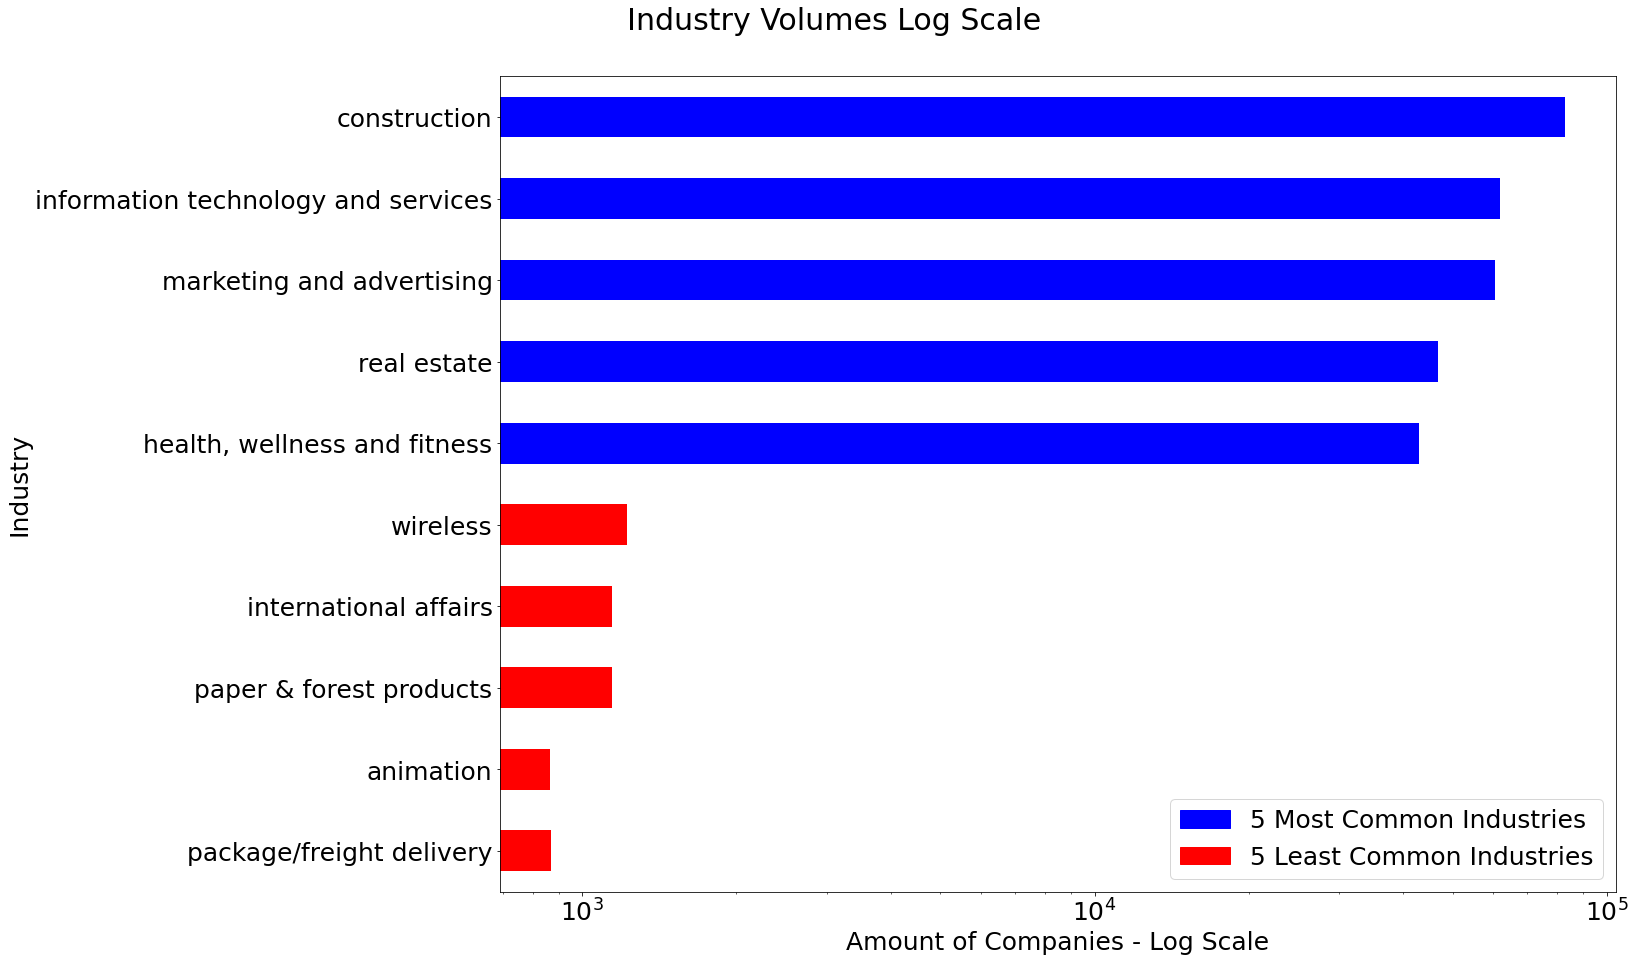

In [11]:
ax = grouped_edges['count'].plot(kind='barh', logx=True, color =['r']*n_industries+['b']*n_industries, figsize=(20, 15), fontsize=25)
colors = {'5 Most Common Industries':'blue', '5 Least Common Industries':'red'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles, labels, fontsize=25)
ax.set_xlabel('Amount of Companies - Log Scale', fontsize=25)
ax.set_ylabel('Industry', fontsize=25);
ax.set_title('Industry Volumes Log Scale', x=0.3 ,y=1.05, fontsize=30);


## Evaluating fasttext model using the regular dataset

In [15]:
def train_model(train_df, fasttext_train_file_path, save_model_path=None):
    print("started writing train file")
    train_df.to_csv(fasttext_train_file_path,
                    index=False,
                    sep=' ',
                    header=None,
                    quoting=csv.QUOTE_NONE,
                    quotechar="",
                    escapechar=" ")

    model_params = {'dim': 90, 'epoch': 14, 'lr': 0.05, 'lrUpdateRate': 100, 'maxn': 0, 'minCount': 1, 'minn': 0,
                    'neg': 5, 't': 0.0001, 'thread': 12, 'verbose': 2, 'ws': 5}
    model = Model(model_params)
    print('started training')
    model.train(fasttext_train_file_path, save_model_path=save_model_path)
    print('finished training')

    return model


def evaluate_model(model, test_df, ind_size_dict, method=None):
    y_pred = model.predict(texts=test_df['text'])
    f1_dict = {}
    f1_dict['micro'] = model.calc_f1(test_ds['industry'], y_pred, 'micro')
    f1_dict['macro'] = model.calc_f1(test_ds['industry'], y_pred, 'macro')
    f1_dict['weighted'] = model.calc_f1(test_ds['industry'], y_pred, 'weighted')
    
    for avg, f1 in f1_dict.items():
        print(f"f1_{avg}: ", round(f1, 3))

    sensitivities = {}
    sizes = []
    for industry in sorted(ind_size_dict.keys()):
        sensitivity_per_ind = model.sensitivity_per_ind(industry, test_ds['industry'], y_pred)
        print("Recall for", industry, ':', round(sensitivity_per_ind, 3), ' \tThe size is:',
              ind_size_dict[industry])
        sensitivities[industry] = sensitivity_per_ind
        sizes.append(ind_size_dict[industry])

    sizes = np.array(list(ind_size_dict.values()))
    
    fig, ax = plt.subplots(figsize=(7.5, 5))
    ax.scatter(np.log(np.array(sizes)), sensitivities.values())
    ax.set_ylim((-0.1, 1.1))
    ax.set_xlabel('Amount of Records in Industry - log scale', fontsize=14)
    ax.set_ylabel('Recall', rotation=0, fontsize=14, labelpad=30)
    ax.set_title(f'Recall Per Industry - {method}', fontsize=16);
    return f1_dict, sensitivities

f1_micro:  0.857
f1_macro:  0.571
f1_weighted:  0.853
Recall for __label__0 : 0.08  	The size is: 1031
Recall for __label__1 : 0.154  	The size is: 1035
Recall for __label__2 : 0.286  	The size is: 1340
Recall for __label__3 : 0.211  	The size is: 1370
Recall for __label__4 : 0.199  	The size is: 1427
Recall for __label__5 : 0.892  	The size is: 50568
Recall for __label__6 : 0.845  	The size is: 54995
Recall for __label__7 : 0.852  	The size is: 71096
Recall for __label__8 : 0.832  	The size is: 73053
Recall for __label__9 : 0.914  	The size is: 97373


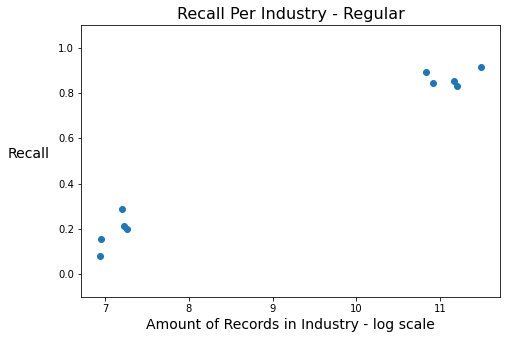

In [16]:
set_seed()

fasttext_train_file_path='/StudentData/Project/Regular/regular_processed_train.txt'
save_model_path = '/StudentData/Project/Regular/regular_model.pth'

used_saved_models = True
if used_saved_models:
    model_reg = Model(saved_model_path=save_model_path)
else:
    model_reg = train_model(frame, fasttext_train_file_path, save_model_path=None)

f1_reg, sensitivities_reg = evaluate_model(model_reg, test_ds, ind_size_dict, 'Regular')

## Undersampling

In [36]:
num_samples_undersample = min(ind_size_dict.values())
num_samples_undersample

1031

In [37]:
def undersample(df: pd.DataFrame, threshold: int, seed: int):
    final_dfs_list = []
    for industry in df.industry.unique():
        temp_df = df[df['industry'] == industry]
        if len(temp_df) > threshold:
            temp_df = temp_df.sample(threshold, random_state=seed)
        final_dfs_list.append(temp_df)
    final_df = pd.concat(final_dfs_list)
    return final_df

In [38]:
undersample_df = undersample(frame, num_samples_undersample, 42)

f1_micro:  0.224
f1_macro:  0.095
f1_weighted:  0.169
Recall for __label__0 : 0.018  	The size is: 1031
Recall for __label__1 : 0.195  	The size is: 1035
Recall for __label__2 : 0.179  	The size is: 1340
Recall for __label__3 : 0.775  	The size is: 1370
Recall for __label__4 : 0.0  	The size is: 1427
Recall for __label__5 : 0.006  	The size is: 50568
Recall for __label__6 : 0.01  	The size is: 54995
Recall for __label__7 : 0.6  	The size is: 71096
Recall for __label__8 : 0.459  	The size is: 73053
Recall for __label__9 : 0.001  	The size is: 97373


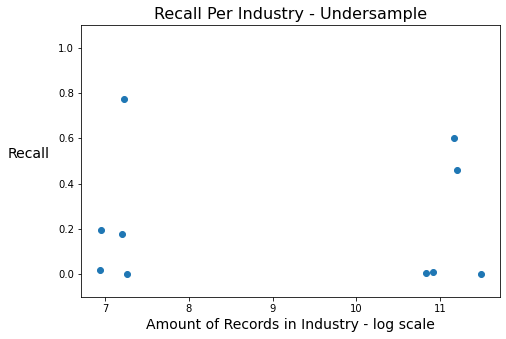

In [17]:
set_seed()
fasttext_train_file_path='/StudentData/Project/Undersampled/undersample_processed_train.txt'
save_model_path = '/StudentData/Project/Undersampled/undersample_model.pth'

used_saved_models = True
if used_saved_models:
    model_undersample = Model(saved_model_path=save_model_path)
else:
    model_undersample = train_model(undersample_df, fasttext_train_file_path, save_model_path=save_model_path)

f1_undersample, sensitivities_undersample = evaluate_model(model_undersample, test_ds, ind_size_dict, 'Undersample')

## Oversampling

In [43]:
num_samples_oversample = max(ind_size_dict.values())
num_samples_oversample

97373

In [44]:
def oversample(df: pd.DataFrame, threshold: int, seed: int):
    final_dfs_list = []
    for industry in df.industry.unique():
        temp_df = df[df['industry'] == industry]
        if len(temp_df) < threshold:
            temp_df = temp_df.sample(threshold, random_state=seed, replace=True)
        final_dfs_list.append(temp_df)
    final_df = pd.concat(final_dfs_list)
    return final_df

In [45]:
oversample_df = oversample(frame, num_samples_oversample, 42)

f1_micro:  0.844
f1_macro:  0.656
f1_weighted:  0.846
Recall for __label__0 : 0.613  	The size is: 1031
Recall for __label__1 : 0.456  	The size is: 1035
Recall for __label__2 : 0.622  	The size is: 1340
Recall for __label__3 : 0.559  	The size is: 1370
Recall for __label__4 : 0.485  	The size is: 1427
Recall for __label__5 : 0.883  	The size is: 50568
Recall for __label__6 : 0.837  	The size is: 54995
Recall for __label__7 : 0.839  	The size is: 71096
Recall for __label__8 : 0.813  	The size is: 73053
Recall for __label__9 : 0.876  	The size is: 97373


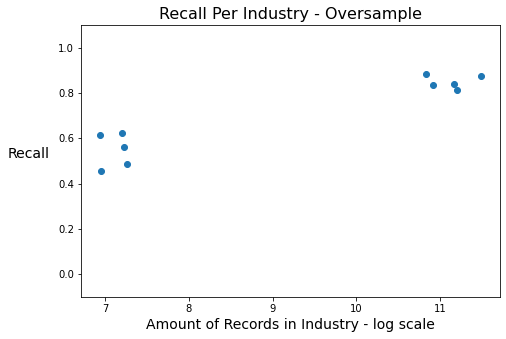

In [18]:
set_seed()
fasttext_train_file_path='/StudentData/Project/Oversampled/oversample_processed_train.txt'
save_model_path = '/StudentData/Project/Oversampled/oversample_model.pth'

used_saved_models = True

if used_saved_models:
    model_oversample = Model(saved_model_path=save_model_path)
else:
    model_oversample = train_model(oversample_df, fasttext_train_file_path, save_model_path=save_model_path)

f1_oversample, sensitivities_oversample = evaluate_model(model_oversample, test_ds, ind_size_dict, 'Oversample')

# Working with generated data

### Loading data from final directory

In [23]:
final_files = glob.glob("/StudentData/Project/Generative/GeneratedOutputs/FinalOutputs/generated_list_*.pkl")
generated_dict = {}
for i, filepath in enumerate(final_files):
    with open(filepath, 'rb') as f:
        generated_dict[int(filepath.split('.pkl')[0][-1])] = pickle.load(f)

In [25]:
def concat_generated_data(df: pd.DataFrame, generated_dict):
    final_dfs_list = [df.copy()]
    for ind_num, generated_list in generated_dict.items():
        temp_generated_df = pd.DataFrame({'text': generated_list, 'industry': [f'__label__{ind_num}']*len(generated_list)})
        final_dfs_list.append(temp_generated_df)
    final_df = pd.concat(final_dfs_list)
    return final_df

In [26]:
generated_df = concat_generated_data(frame, generated_dict)

started writing train file
started training
finished training
f1_micro:  0.859
f1_macro:  0.692
f1_weighted:  0.858
Recall for __label__0 : 0.448  	The size is: 1031
Recall for __label__1 : 0.355  	The size is: 1035
Recall for __label__2 : 0.541  	The size is: 1340
Recall for __label__3 : 0.432  	The size is: 1370
Recall for __label__4 : 0.379  	The size is: 1427
Recall for __label__5 : 0.888  	The size is: 50568
Recall for __label__6 : 0.843  	The size is: 54995
Recall for __label__7 : 0.85  	The size is: 71096
Recall for __label__8 : 0.826  	The size is: 73053
Recall for __label__9 : 0.912  	The size is: 97373


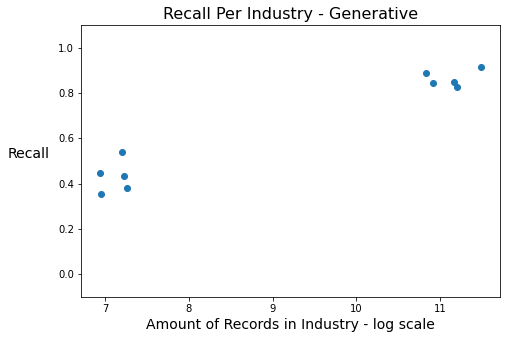

In [27]:
set_seed()

fasttext_train_file_path='/StudentData/Project/Generative/generated_processed_train.txt'
save_model_path = '/StudentData/Project/Generative/generated_model.pth'

used_saved_models = False
if used_saved_models:
    model_generated = Model(saved_model_path=save_model_path)
else:
    model_generated = train_model(generated_df, fasttext_train_file_path, save_model_path=save_model_path)

f1_generated, sensitivities_generated = evaluate_model(model_generated, test_ds, ind_size_dict, 'Generative')

## Comparing results from all models

In [32]:
rows = []
for (ind, reg_sen, under_sen, over_sen, gen_sen) in zip(sensitivities_reg.keys(), sensitivities_reg.values(), 
                                                       sensitivities_undersample.values(), sensitivities_oversample.values(),
                                                       sensitivities_generated.values()):
    rows.append([ind, reg_sen, under_sen, over_sen, gen_sen])
recall_df = pd.DataFrame(rows,
                  columns=['Industry', 'Regular', 'Undersample', 'Oversample', 'Generate'])

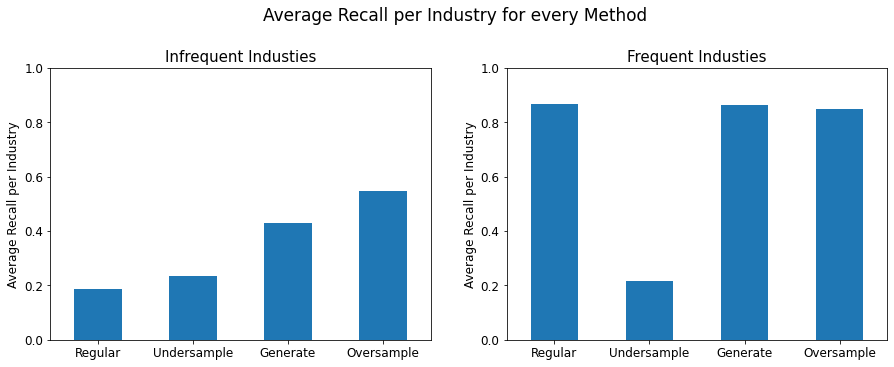

In [40]:
recall_df['size'] = recall_df['Industry'].apply(lambda x: 'Infrequent' if int(x[-1]) <5 else 'Frequent')
frequent_df = recall_df[recall_df['size'] == 'Frequent']
infrequent_df = recall_df[recall_df['size'] == 'Infrequent']

fig, axs = plt.subplots(1, 2, figsize=(15,5))
column_order = ['Industry', 'Regular', 'Undersample', 'Generate', 'Oversample']
infrequent_df[column_order].mean().plot.bar(ax=axs[0], rot=0, fontsize=12)
frequent_df[column_order].mean().plot.bar(ax=axs[1], rot=0, fontsize=12)
fig.suptitle('Average Recall per Industry for every Method', fontsize=17, y=1.05)
axs[0].set_title('Infrequent Industies', fontsize=15)
axs[1].set_title('Frequent Industies', fontsize=15)
axs[0].set_ylabel('Average Recall per Industry', fontsize=12)
axs[1].set_ylabel('Average Recall per Industry', fontsize=12)
axs[0].set_ylim(0, 1)
axs[1].set_ylim(0, 1);

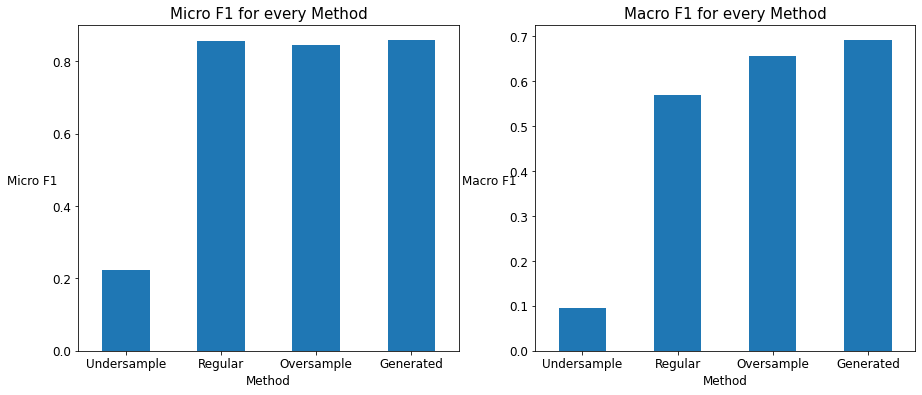

In [31]:
f1_df = pd.DataFrame([['Regular']+list(f1_reg.values()), ['Undersample']+list(f1_undersample.values()), \
                     ['Oversample']+list(f1_oversample.values()), ['Generated']+list(f1_generated.values())], \
                  columns=['Method', 'Micro F1', 'Macro F1', 'f1-wieghted']).set_index('Method', drop=True)

fig, axs = plt.subplots(1, 2, figsize=(15,6))
# plot grouped bar chart
row_order = ['Undersample', 'Regular', 'Oversample', 'Generated']

for i, meassure in enumerate(['Micro F1', 'Macro F1']):
    f1_df.loc[row_order][[meassure]].plot(kind='bar', stacked=False, ax=axs[i], rot=0, fontsize=12, legend=False)
    axs[i].set_title(f'{meassure} for every Method', fontsize=15)
    axs[i].set_ylabel(f'{meassure}', rotation=0, labelpad=20, fontsize=12);
    axs[i].set_xlabel('Method',fontsize=12);


### Comparing fine tuned T5 to pre-trained

In [34]:
from transformers import T5ForConditionalGeneration, AutoTokenizer


In [35]:
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained(f'/StudentData/Project/Generative/Models/model_0.hfm')

In [36]:
text_input = 'summarize: package freight delivery. UPS delivery, ordering delivery service has never been faster and easier'
inputs = tokenizer(text_input, return_tensors="pt", padding=True)

In [37]:
outputs = model.generate(
    input_ids=inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    do_sample=False,
    num_beams=4, no_repeat_ngram_size=2, min_length=200, max_length=300
)

### This is an example of generated text

In [38]:
tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

"UPS delivery, ordering delivery service has never been faster and easier. the fastest and easiest way to get a package delivered is to use the UPS courier service, which is based in california. UPS is the world's largest courier company, supplying the highest quality of service to our customers. We are able to deliver your package in as little as 24 hours. You can expect to receive your packages in less than 48 hours if you choose to order with us. The fastest, most efficient and most cost-effective way of getting the packages you need to be delivered to you in the most expedited delivery method is by using the courier services are available to your home delivery services, such as e-mail delivery and the same day delivery & retransmission service provider, the largest and fastest shipping service providers, and u.s. and other international shipping services and courier companies, as well as courier couriers, in just 24 hour "

### This is an example of real text

In [284]:
frame[frame['industry'] == '__label__0']['text'].iloc[7].lower()

' since 2000, we have provided quality services across southwestern ontario including hamilton, burlington, london, brantford, woodstock, and orangeville. our friendly, professional, uniformed move teams are highly efficient and will make your move smooth. we take a 100 service-oriented attitude with each project. our hours are flexible to work around your busy schedule and all moves are conducted with the utmost professionalism. we are available for office moves, internal moves, office furniture installation and reconfiguration and plastic moving bins rentals. the easier office relocation & moving solution there is no magic wand that will make your move easy but, proper planning will. that is why our project planner will meet with you to coordinate your move prior to your moving date. this will not only save you from unnecessary headaches, but will also make the move happen that much faster. and, because we care about our clients no matter what time of day it is, we also offer after-h